<h1>Exploring GeoSpatial Imagery Classification Pipeline and Normalized Difference Vegetation Index ("NDVI") Analysis - "Model Notebook"</h1>

<h2>Final Project of Deep Learning Foundation (ELEC ENG 435)</h2>
<h3>Group Member: Zhili Wang (solo) </h3>

<h1>Presentation Youtube Link</h1>

https://www.youtube.com/channel/UCG5Rx8GLhQDCmeCYK0CHSQA/videos?view_as=subscriber

<h1>Structure of Two Notebooks</h1>
Due to a lack of GPU hardware or a premium Google-drive account (I have to utilize Colab's free GPU access, but the data for this project exceeded a free Google-drive account's 15-GB limit), I apologize and divided my work into the following 2 notebooks:

* Preprocessing & NDVI Notebook (ran with local data):
  - Brief EDA
  - Convert train set sponsored by Kaggle to a .npz file (amazon.npz) with Numpy.savez() function
  - Demonstrate a few NDVI explorations

* Model Notebook (this notebook, trained on colab with converted data):
  - Image classification CNN models exploration with the "amazon.npz" data mentioned above
  - Model improvement attempts
  - Model selection and prediction

<h1> Main Objectives </h1>

Preparing for Professor Katsaggelos' geospatial research regarding change of environemnt, such as declining in urban vegetation covers and deforestations. Specific tasks of this project includes:

- Familiarizing myself with the pipeline of preprocessing satellite imagery and EDA 
- Understanding NVDI concepts and perform relevant basic analysis
- Exploring performances of Convolutional Neural Network models and transfer learning in image classifications
- Testing as many model improvement techniques as possible


<h1>Statement of Purpose / Changing Topic:</h1>
    After attending one of Professor Katsaggelos' weekly meeting, I have been inspired by his idea of applying deep learning concepts on earth science topics via GeoSpatial imagery. In order to prepare for any of his upcoming research, I wanted to familiarize myself with image processing pipelines, using a relevant dataset.

<h1> Source of Data </h1>
Satelitte imagery of the Amazon Rainforest from a past 2017 Kaggle competition:
    
https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data

Note: Under time-restriction and some unsolvable system errors, I was not able to deploy a third party satelitte image pipeline (e.g. Google Earth API) to customize location of our data to an urban environment in the United States, after several failed attempts.

<h1>References</h1>
I would like to thank and give credits to the following sources:

* Deep Learning by Ian Goodfellow, Yoshua Bengio and Aaron Courville

* I learned from Mr. James Le's idea in his post "The 4 Convolutional Neural Network Models That Can Classify Your Fashion Images" for models improvement techniques and used some lines of his CNN architecture codes:
https://towardsdatascience.com/the-4-convolutional-neural-network-models-that-can-classify-your-fashion-images-9fe7f3e5399d

* For my NDVI analysis and data extraction, I used some codes from this GeoSpatial Data Workshop:
https://www.kaggle.com/jcarrillo/machine-learning-for-geospatial-data-workshop-2a

* How to Reduce Overfitting with Dropouts:
https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

Import all the packages we need 

In [1]:
import numpy as np
import pandas as pd
import keras
import sys
import os
import gc
import matplotlib.pyplot as plt 
from pandas import read_csv
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
# from keras.layers import Dropout
from keras.optimizers import SGD
from keras import backend
# from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
#from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# disabled tensorflow deprecation warnings, but doesn't seem to work in TF 2.1
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

# expand colab cell width
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:100% !important; }</style>"))

Using TensorFlow backend.


In [86]:
map_csv = read_csv('/Users/zhiliwang/Documents/nu_dl/forest/data/train_v2.csv')
print(map_csv.shape)
print(map_csv)

(40479, 2)
        image_name                                           tags
0          train_0                                   haze primary
1          train_1                agriculture clear primary water
2          train_2                                  clear primary
3          train_3                                  clear primary
4          train_4      agriculture clear habitation primary road
...            ...                                            ...
40474  train_40474                                  clear primary
40475  train_40475                                         cloudy
40476  train_40476                      agriculture clear primary
40477  train_40477                 agriculture clear primary road
40478  train_40478  agriculture cultivation partly_cloudy primary

[40479 rows x 2 columns]


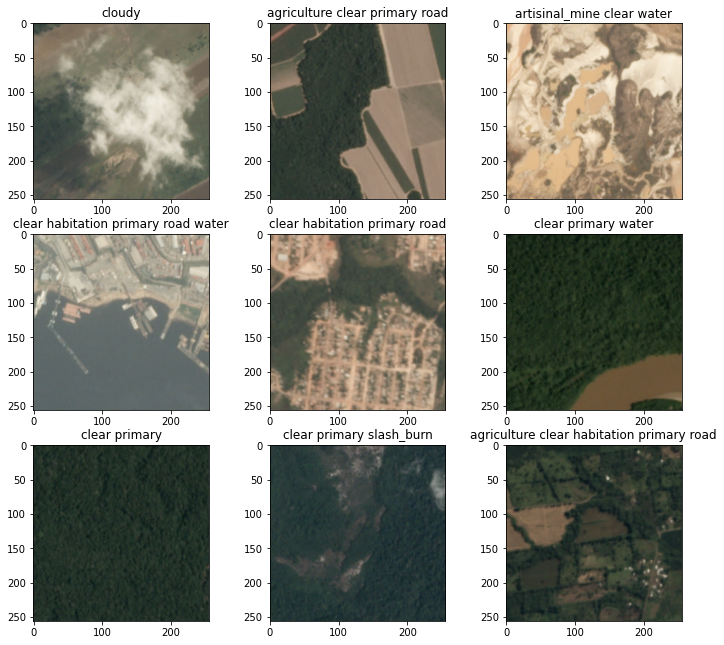

In [93]:
from glob import glob

imgs_path = sorted(glob('/Users/zhiliwang/Documents/nu_dl/forest/data/train-jpg/*.jpg'))
selected = [9006, 8002, 13003, 16004, 14001, 15000, 11006, 4005, 12007]

# get image paths for selected pics
imgs_ls = []
for i in selected:
    imgs_ls.append(imgs_path[i])

# get their actual indices for labels
imgs_label_index = []
for z in imgs_ls:
    dex = (z.split("train_")[1].split('.'))[0]
    imgs_label_index.append(int(dex))

plt.figure(figsize=(12,11))
for j in range(9): 
    plt.subplot(3, 3, j + 1)
    plt.imshow(plt.imread(imgs_ls[j]))
    temp = imgs_label_index[j]
    plt.title(map_csv['tags'][temp])
plt.show()

<h1>NDVI</h1>

* This part can only done with a .tif file, which is an image file saved in a high-quality graphics format
* The higher the NDVI, the stronger/healthier the vegetation cover is
* Strong-weak descent is by default presented in Red-Green-Blue order

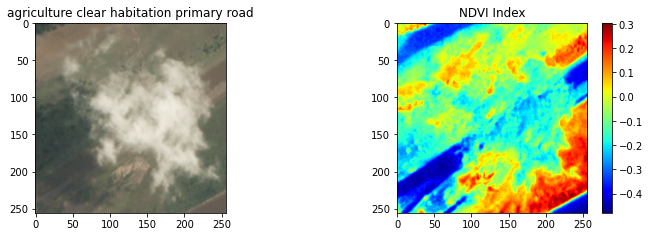

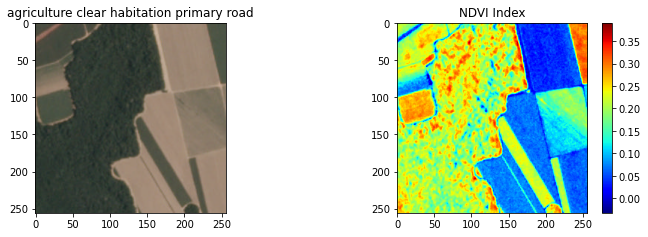

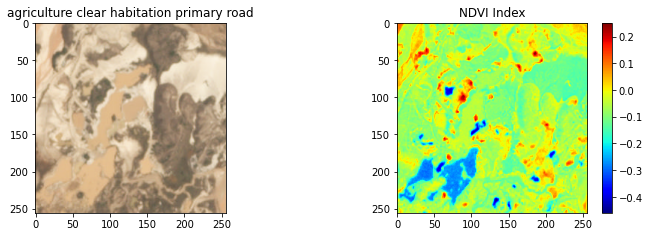

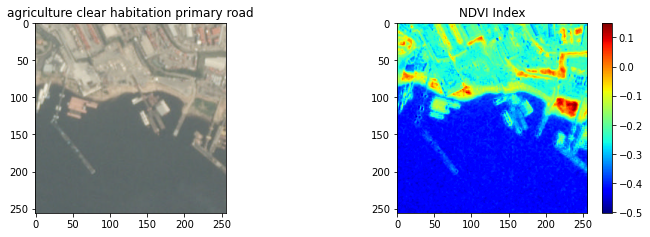

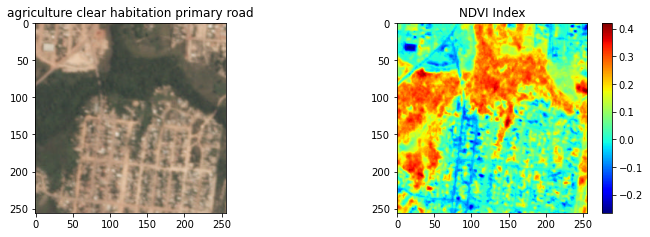

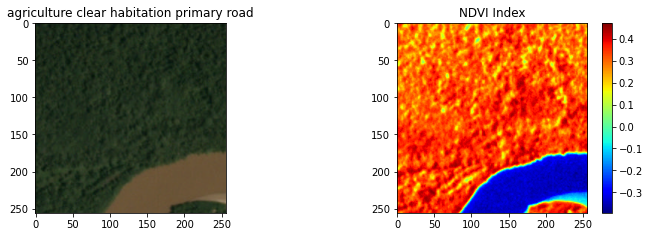

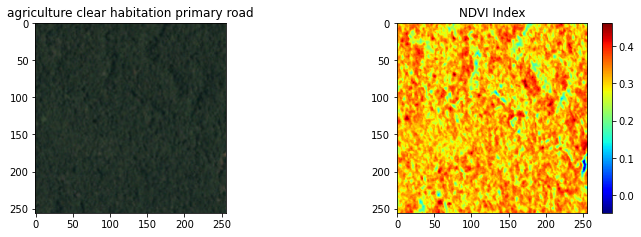

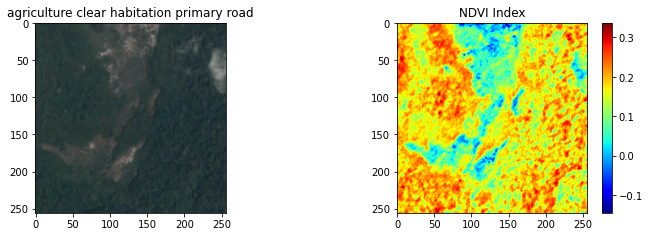

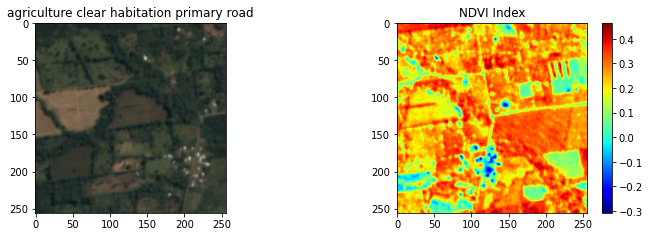

In [97]:
# !pip install -U -q tifffile
import tifffile
from skimage import io

tifs_path = sorted(glob('/Users/zhiliwang/Documents/nu_dl/forest/data/train-tif-v2/*.tif'))

tifs_ls = []
for k in selected:
    tifs_ls.append(tifs_path[k])

# Calculate NDVI
imgs = [io.imread(path) / io.imread(path).max() for path in tifs_ls]
#r, g, b, nir = img[:, :, 0], img[:, :, 1], img[:, :, 2], img[:, :, 3]
ndvis = [(img[:,:,3] - img[:,:,0])/((img[:,:,3] + img[:,:,0])) for img in imgs]

for i in range(9):
    img_id = i
    plt.figure(figsize=(12,3.5))
    plt.subplot(121)
    plt.title(map_csv['tags'][temp])
    plt.imshow(plt.imread(imgs_ls[img_id]))
    plt.subplot(122)
    plt.title('NDVI Index')
    plt.imshow(ndvis[img_id], cmap='jet')
    plt.colorbar()
    plt.show()

<h2>From here we need PyDrive must train, test and save models within Google Colab (Colab cannot access or save files locally)

In [0]:
#pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

In [0]:
def load_dataset():
    # load structured .npz data
    # separate amazon.npz into training and testing at a 7:3 ratio
    data = np.load('/content/drive/My Drive/dl_final_data/amazon.npz')
    X, y = data['arr_0'], data['arr_1']
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    return trainX, trainY, testX, testY

In [0]:
def fbeta(y_true, y_pred, beta=2):
    # remove predictions
    # calculate fbeta score for multi-class/label classification
    y_pred = backend.clip(y_pred, 0, 1)
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # precision
    p = tp / (tp + fp + backend.epsilon())
    # recall
    r = tp / (tp + fn + backend.epsilon())
    # calculate fbeta, averaged across each class
    fbeta_score = backend.mean((1 + beta ** 2) * (p * r) / ((beta ** 2) * p + r + backend.epsilon()))
    return fbeta_score

In [0]:
# define cnn model
def cnn_model(in_shape=(128, 128, 3), out_shape=17):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [0]:
# plot diagnostic learning curves
def plot_diag(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('F-Beta')
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='red', label='test')
    plt.subplots_adjust(left = 0.125, right = 0.9, bottom = 0.1, top = 2.1, wspace = 0.2, hspace = 0.2)
    plt.show()

In [0]:
# run the test evaluate model
def test_cnn():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # iterators
    train_it = datagen.flow(trainX, trainY, batch_size=128)
    test_it = datagen.flow(testX, testY, batch_size=128)
    # define and fit model
    model = cnn_model()
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
    # evaluate model
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('Loss=%.3f, F-Beta=%.3f' % (loss, fbeta))
    # learning curves
    plot_diag(history)
    '''
    model.save('model_base.h5')
    model_file = drive.CreateFile({'title' : 'model_base.h5'})  
    model_file.SetContentFile('model_base.h5')                       
    model_file.Upload() 
    print("Model is saved.")
    # download to google drive                       
    drive.CreateFile({'id': model_file.get('id')})
    print("Model downloaded to google drive.")
    '''

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)














Loss=0.145, F-Beta=0.831


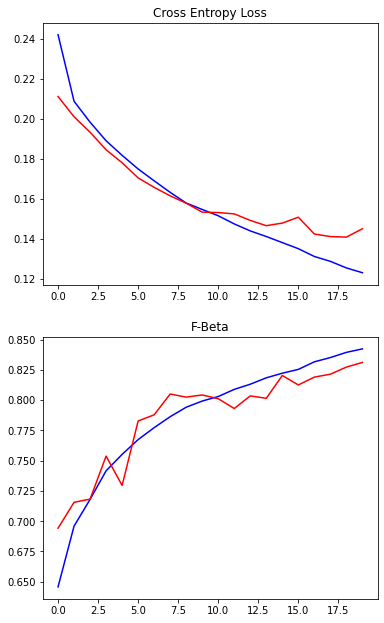

In [0]:
# entry point, run the test harness
test_cnn()

A 83.10% accuracy is not too bad, but I am concerned about the model having an overfitting tendency after rough the 13-14th epoch. 

<h1><h>

<h1> Adding Dropout For Overfitting </h1>







Due to my concern for overfitting tendency, I add a 20% dropout regularization to each VGG block and a 50% dropout to a fully connected layers when it performs classifications

I was assuming that I could re-use functions with same name simply by calling them, but Colab is acting up without plotting any graph. From now on a lot of code and package must be re-defined or re-called in order for Colab to plot learning curves. Please bear with me. I will aggregate blocks of functions if they have identical definitions with the previous ones, just like this one below:

In [0]:
# load_data, f-beta, and plot functions stay identical
def load_dataset():
    # load structured .npz data
    # separate amazon.npz into training and testing at a 7:3 ratio
    data = np.load('/content/drive/My Drive/dl_final_data/amazon.npz')
    X, y = data['arr_0'], data['arr_1']
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    return trainX, trainY, testX, testY


def fbeta(y_true, y_pred, beta=2):
    # remove predictions
    # calculate fbeta score for multi-class/label classification
    y_pred = backend.clip(y_pred, 0, 1)
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # precision
    p = tp / (tp + fp + backend.epsilon())
    # recall
    r = tp / (tp + fn + backend.epsilon())
    # calculate fbeta, averaged across each class
    fbeta_score = backend.mean((1 + beta ** 2) * (p * r) / ((beta ** 2) * p + r + backend.epsilon()))
    return fbeta_score

def plot_diag(history):
    # plot loss vs accuracy
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.subplot(212)
    plt.title('F-Beta')
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='red', label='test')
    plt.subplots_adjust(left = 0.125, right = 0.9, bottom = 0.1, top = 2.1, wspace = 0.2, hspace = 0.2)
    plt.show()

In [0]:
# improving model and reducing overfit with dropout:
# almost identical definition with baseline model but adding dropout 

from keras.layers import Dropout

def cnn_model_dropout(in_shape=(128, 128, 3), out_shape=17):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [0]:
# test model and potentially save it to google drive
def test_cnn_dropout():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = datagen.flow(trainX, trainY, batch_size=128)
    test_it = datagen.flow(testX, testY, batch_size=128)
    # define model
    model = cnn_model_dropout()
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
    # evaluate model
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('Loss=%.3f, F-Beta=%.3f' % (loss, fbeta))
    # learning curves
    plot_diag(history)
    '''
    model.save('model_base_dropout.h5')
    model_file = drive.CreateFile({'title' : 'model_base_dropout.h5'})  
    model_file.SetContentFile('model_base_dropout.h5')                       
    model_file.Upload() 
    print("Model is saved.")
    # download to google drive                       
    drive.CreateFile({'id': model_file.get('id')})
    print("Model downloaded to google drive.")
    '''

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)

Loss=0.153, F-Beta=0.804


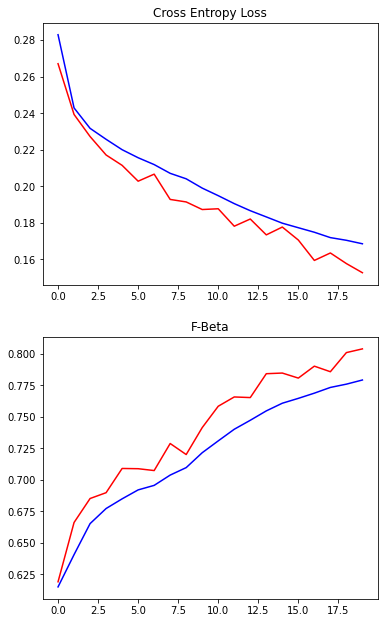

In [0]:
# entry point, run the test harness
# this time with dropout
# maybe adding more epochs? i tried it before but more overfitting than less epochs
test_cnn_dropout()

<h1> Image Data Augmentation </h1>


We got a lower accuracy of 80.4% from the model above, but fix the tendency of overfitting.

There are 28,335 images in the training data, which may not be enough to get a good model.

I think it's a good idea here to flip and rotate the images to create modified datasets to expand our training set. Even though this creates some more noise, but won't discourage the model to learn the same image features.



In [0]:
# identical functions from above, must re-define them to plot

def load_dataset():
    # load structured .npz data
    # separate amazon.npz into training and testing at a 7:3 ratio
    data = np.load('/content/drive/My Drive/dl_final_data/amazon.npz')
    X, y = data['arr_0'], data['arr_1']
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    return trainX, trainY, testX, testY

def fbeta(y_true, y_pred, beta=2):
    # remove predictions
    # calculate fbeta score for multi-class/label classification
    y_pred = backend.clip(y_pred, 0, 1)
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # precision
    p = tp / (tp + fp + backend.epsilon())
    # recall
    r = tp / (tp + fn + backend.epsilon())
    # calculate fbeta, averaged across each class
    fbeta_score = backend.mean((1 + beta ** 2) * (p * r) / ((beta ** 2) * p + r + backend.epsilon()))
    return fbeta_score

def plot_diag(history):
    # plot loss vs accuracy
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.subplot(212)
    plt.title('F-Beta')
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='red', label='test')
    plt.subplots_adjust(left = 0.125, right = 0.9, bottom = 0.1, top = 2.1, wspace = 0.2, hspace = 0.2)
    plt.show()

In [0]:
# image data augmentation
# control variates: using the original cnn
def cnn_model_aug(in_shape=(128, 128, 3), out_shape=17):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [0]:
def test_cnn_aug():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # adding flips:
    train_datagen = ImageDataGenerator(rescale = 1.0/255.0, horizontal_flip = True, vertical_flip = True, rotation_range = 90)
    test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
    # prepare iterators
    train_it = train_datagen.flow(trainX, trainY, batch_size = 128)
    test_it = test_datagen.flow(testX, testY, batch_size = 128)
    # model definition and fitting
    model = cnn_model_aug()
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs = 20, verbose = 0)
    # model evaluation
    loss, fbeta = model.evaluate_generator(test_it, steps = len(test_it), verbose = 0)
    print('Loss=%.3f, F-Beta=%.3f' % (loss, fbeta))
    # learning curves
    plot_diag(history)
    # save model to g-drive
    model.save('model_base_aug.h5')
    model_file = drive.CreateFile({'title' : 'model_base_aug.h5'})  
    model_file.SetContentFile('model_base_aug.h5')                       
    model_file.Upload() 
    print("Model is saved.")
    # download to google drive                       
    drive.CreateFile({'id': model_file.get('id')})
    print("Model downloaded to google drive.")

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)














Loss=0.140, F-Beta=0.811


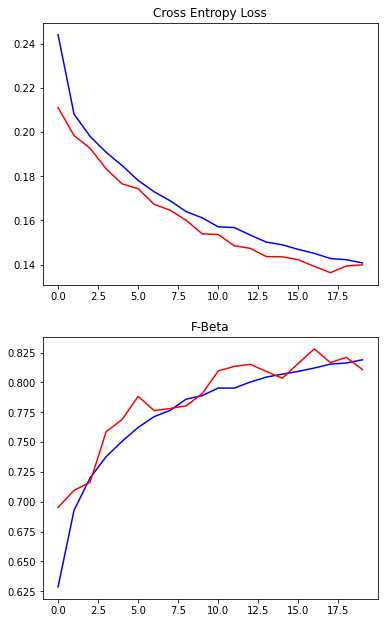

Model is saved.
Model downloaded to google drive.


In [0]:
test_cnn_aug()

<h1>VGG-16 Model</h1> 



In [0]:
# identical functions from above, must re-define them to plot

def load_dataset():
    # load structured .npz data
    # separate amazon.npz into training and testing at a 7:3 ratio
    data = np.load('/content/drive/My Drive/dl_final_data/amazon.npz')
    X, y = data['arr_0'], data['arr_1']
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    return trainX, trainY, testX, testY

def fbeta(y_true, y_pred, beta=2):
    # remove predictions
    # calculate fbeta score for multi-class/label classification
    y_pred = backend.clip(y_pred, 0, 1)
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # precision
    p = tp / (tp + fp + backend.epsilon())
    # recall
    r = tp / (tp + fn + backend.epsilon())
    # calculate fbeta, averaged across each class
    fbeta_score = backend.mean((1 + beta ** 2) * (p * r) / ((beta ** 2) * p + r + backend.epsilon()))
    return fbeta_score

def plot_diag(history):
    # plot loss vs accuracy
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.subplot(212)
    plt.title('F-Beta')
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='red', label='test')
    plt.subplots_adjust(left = 0.125, right = 0.9, bottom = 0.1, top = 2.1, wspace = 0.2, hspace = 0.2)
    plt.show()

In [0]:
from keras.applications.vgg16 import VGG16

def vgg16_model(in_shape=(128, 128, 3), out_shape=17):
    # load model
    model = VGG16(include_top=False, input_shape=in_shape)
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # allow last vgg block to be trainable
    model.get_layer('block5_conv1').trainable = True
    model.get_layer('block5_conv2').trainable = True
    model.get_layer('block5_conv3').trainable = True
    model.get_layer('block5_pool').trainable = True
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(out_shape, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [0]:
def test_vgg_aug():
    trainX, trainY, testX, testY = load_dataset()
    # create data generator
    train_datagen = ImageDataGenerator(featurewise_center=True, horizontal_flip=True, vertical_flip=True, rotation_range=90)
    test_datagen = ImageDataGenerator(featurewise_center=True)
    # flip image-net mean pixel intensity for RGB values for centering
    train_datagen.mean = [123.68, 116.779, 103.939]
    test_datagen.mean = [123.68, 116.779, 103.939]
    # iterators
    train_it = train_datagen.flow(trainX, trainY, batch_size=128)
    test_it = test_datagen.flow(testX, testY, batch_size=128)
    # define and fit model
    model = vgg16_model()
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
    # evaluate model
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('Loss = %.3f, F-Beta = %.3f' % (loss, fbeta))
    # learning curves
    plot_diag(history)

    # save model
    model.save('model.h5')
    model_file = drive.CreateFile({'title' : 'model.h5'})
    model_file.SetContentFile('model.h5')
    model_file.Upload()
    print("Model is saved.")
    # download to google drive                       
    drive.CreateFile({'id': model_file.get('id')})
    print("Model downloaded to google drive.")

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)














Loss = 0.095, F-Beta = 0.894


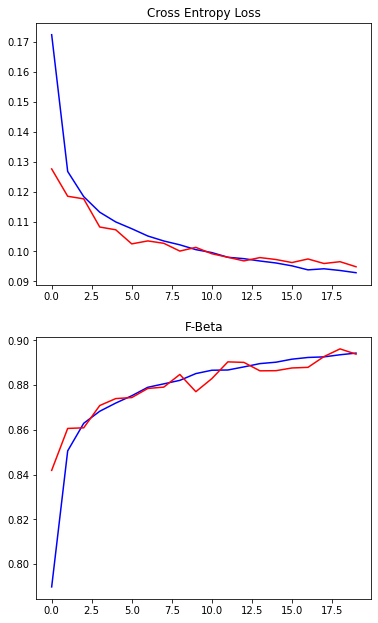

Model is saved.
Model downloaded to google drive.


In [9]:
test_vgg_aug()

In [0]:
# only if you want to access that model right away:
# file_obj = drive.CreaeFile({'id': 'get-id'})                       
# file_obj.GetContentFile('model.h5')

<h1>Prediction</h1>
For data-retrival convenience, we downloaded 'model.h5' and run the rest of the demo locally

<h1> Future Directions </h1>

* Access to a GPU to connect the entire project into one single pipeline
* Investigate methods and API to access GeoSpatial imagery data with customized locations
* Try to write a program to show ImageNet's mean pixel intensity value
* Fit this structured dataset to other "hot" models in the current industry, such as AlexNet
* Research how to deal with noise in satellite imagery (cloud, fog, etc.)
* Research on differentiating similar images (e.g. natural cover vs crops vs golf courts)